In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from dezerogym.gridworld import GridWorld

In [2]:
class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = reward + self.gamma * G
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

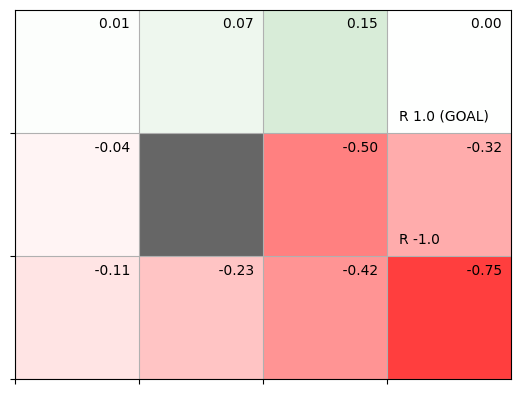

In [3]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break
            
        state = next_state

env.render_v(agent.V)


In [4]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

In [5]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0) #Q instead of V
        # self.cnts = defaultdict(lambda: 0)
        self.memeory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memeory.append(data)
    
    def reset(self):
        self.memeory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memeory):
            state, action, reward = data
            G = reward + self.gamma * G
            key = (state, action)
            # self.cnts[state] += 1

            alpha = 0.1
            self.Q[key] += (G - self.Q[key]) * alpha

            self.pi[state] = greedy_probs(self.Q, state)

In [6]:
env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break
        
        state = next_state

env.render_q(agent.Q)

KeyboardInterrupt: 

In [7]:
import numpy as np

x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

e = np.sum(x * pi)
print('True value(E_pi[x]):', e)

n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)
    samples.append(s)

mean = np.mean(samples)
var = np.var(samples)
print("MC: {:.2f} (Var: {:.2f})".format(mean, var))

True value(E_pi[x]): 2.7
MC: 2.66 (Var: 0.46)


In [10]:
# b = np.array([1/3, 1/3, 1/3])
b = np.array([0.2, 0.2, 0.6])
n = 100
samples = []

for _ in range(n):
    idx = np.arange(len(b))
    i = np.random.choice(idx, p=b)
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)

mean = np.mean(samples)
var = np.var(samples)
print("MC: {:.2f} (Var: {:.2f})".format(mean, var))


MC: 2.58 (Var: 2.70)


In [11]:
import numpy as np
from dezerogym.gridworld import GridWorld

class McOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.2
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action , reward)
        self.memory.append(data)
    
    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        rho = 1

        for data in reversed(self.memory):
            state, action, reward = data
            key = (state, action)

            G = reward + self.gamma * rho * G
            self.Q[key] += (G - self.Q[key]) * self.alpha
            rho *= self.pi[state][action] / self.b[state][action]

            self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_probs(self.Q, state, self.epsilon)

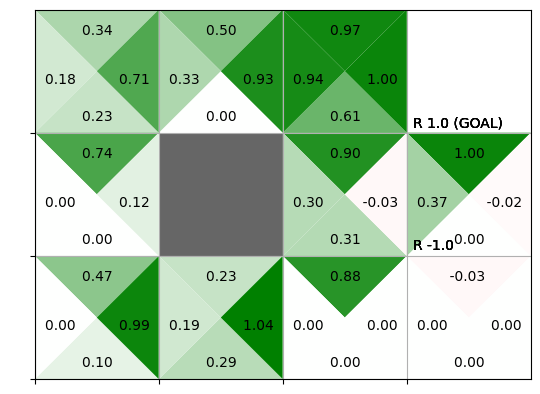

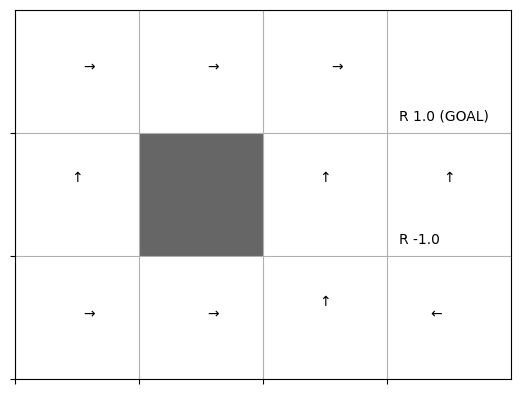

In [13]:
env = GridWorld()
agent = McOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break
        
        state = next_state

env.render_q(agent.Q)